# **Attririon**

We aim to focus on two tpoics in this notebook:

- Predict who might leave
- Find out why some leave

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0) Imports

In [ ]:
!pip install shap
!pip install lime

     |████████████████████████████████| 564 kB 5.2 MB/s 
     |████████████████████████████████| 275 kB 5.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=67b5e6befe621544db68390a2c616d09f4a61e4a3bb82aa57009383d5b71ecd6
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score,  \
                            silhouette_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,  \
                            classification_report
from sklearn.inspection import permutation_importance, plot_partial_dependence
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import shap

from lime.lime_tabular import LimeTabularExplainer

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/content/drive/MyDrive/Roche/Colab/data.csv')

In [ ]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Departments ', 'salary'],
      dtype='object')

# 1) Helper functions

In [ ]:
def make_lime(lime_explainer, instance, model):

    exp = lime_explainer.explain_instance(instance, model.predict_proba, num_features = x_train.shape[1])
    plt.figure(figsize = (16, 12))
    exp.as_pyplot_figure()
    plt.tight_layout()

    for item in exp.as_list():
        print(item)
        

def plot_precent_left(df, col):
    ind = df.groupby(col)['left'].sum().sort_index().index
    num_left = np.array(df.groupby(col)['left'].sum().sort_index().to_list())
    num_cat = np.array(df[col].value_counts().sort_index().to_list())
    ans = 100 * num_left / num_cat
    ans = dict(zip(ind, ans))
    plt.figure(figsize = (12, 6))
    plt.bar(x = ans.keys(), height = ans.values())
    plt.title(f'precent of people left in each class of the {col}');
    
    
    
def make_countplots(df):
    for col in df.select_dtypes(['number']):
        if col in ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company',
                   'Departments ', 'salary']:
            fig, ax = plt.subplots()
            sns.boxplot(x = 'left', y = col, data = df);
            plt.title(col);
            #ax.legend(["stayed", "left"], loc = 'best');
            
            
            
def make_kde(df):
    for col in df.select_dtypes(['number']):
        if col in ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company',
                   'Departments ', 'salary']:
            fig, ax = plt.subplots()
            sns.kdeplot(df[df['left'] == 0][col], label = 'stayed', shade = True, color = 'r')
            sns.kdeplot(df[df['left'] == 1][col], label = 'left', shade = True, color = 'b')
            plt.title(col);
            ax.legend(['stayed', 'left']);
            
            
plt.rcParams["figure.figsize"] = (10, 6)

In [ ]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Departments ', 'salary'],
      dtype='object')

# 2) Data Processing and  Exploratory Data Analysis 

### Columns:
**satisfaction_level:** from 0-1.       
**last_evaluation:** from 0-1.       
**number_projects:** numbers of projects     
**average_monthly_hours:** average numbers of worked hours       
**time_spent_company:** number of years in the company      
**work_accident:** had a work accident?          
**promotion_last_5years:** if an employee had a promotion in the last 5 years       
**Departments:** department name      
**Salary:** pay band      
**left:** 0 means stayed, 1 means left       

In [ ]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Departments,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Departments            14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [ ]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [ ]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Departments ', 'salary'],
      dtype='object')

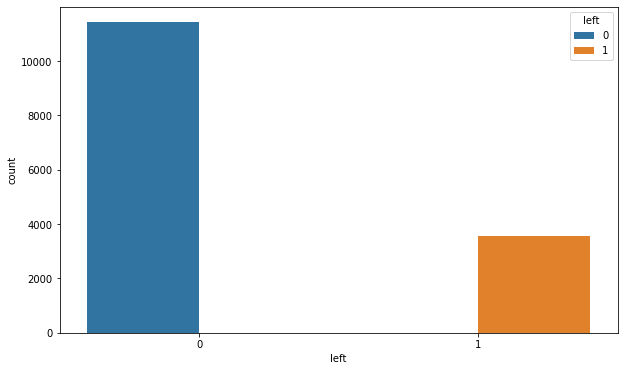

In [ ]:
sns.countplot(df['left'], hue = df['left']);

In [ ]:
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Departments,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


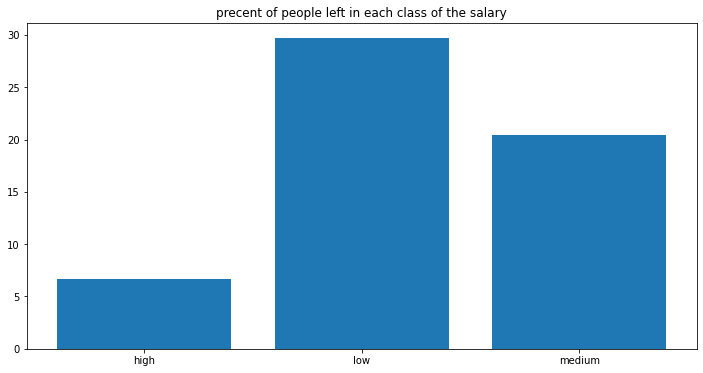

In [ ]:
plot_precent_left(df, 'salary')

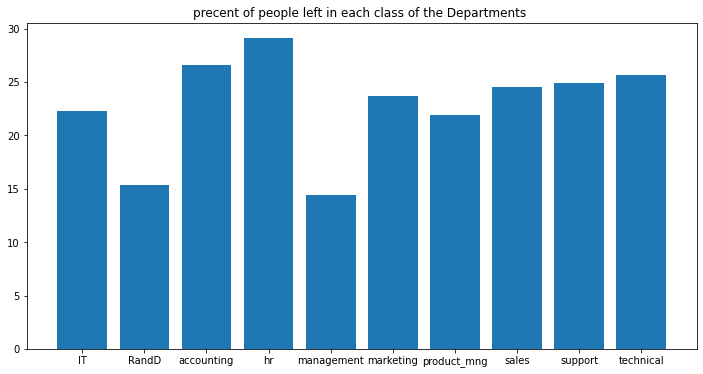

In [ ]:
plot_precent_left(df, 'Departments ')

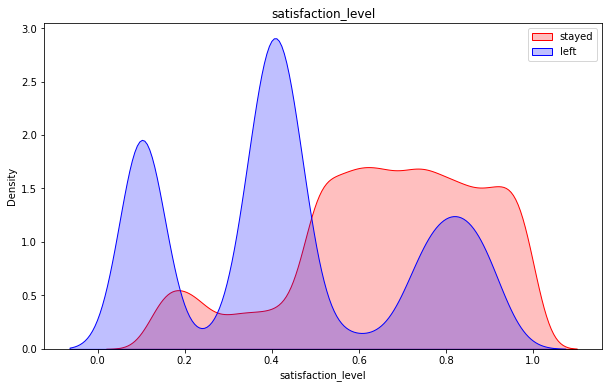

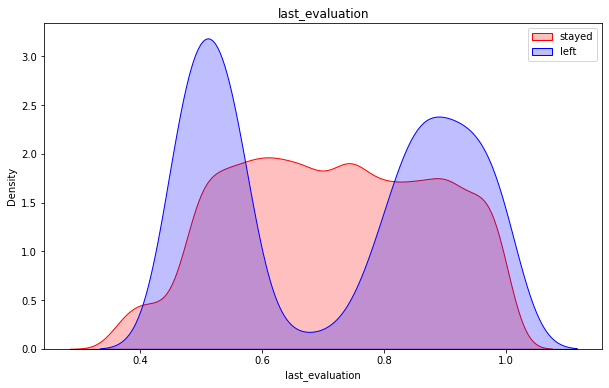

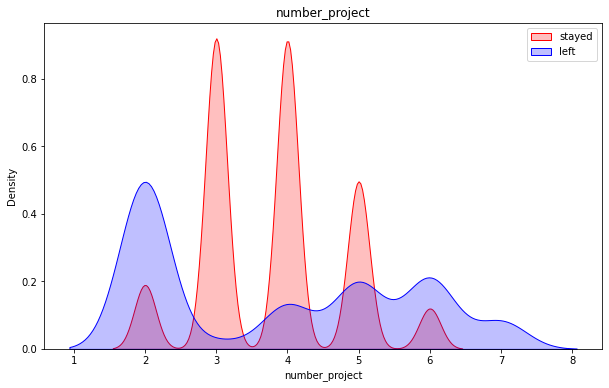

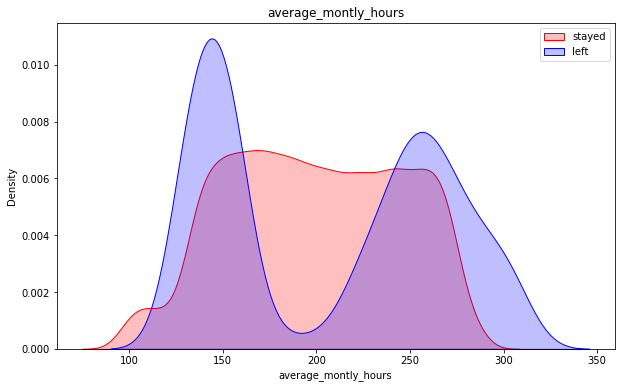

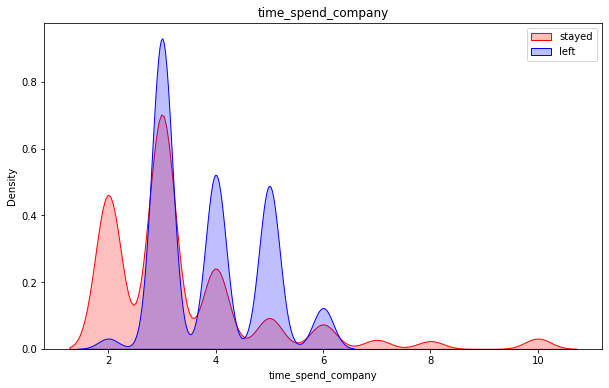

In [ ]:
make_kde(df)

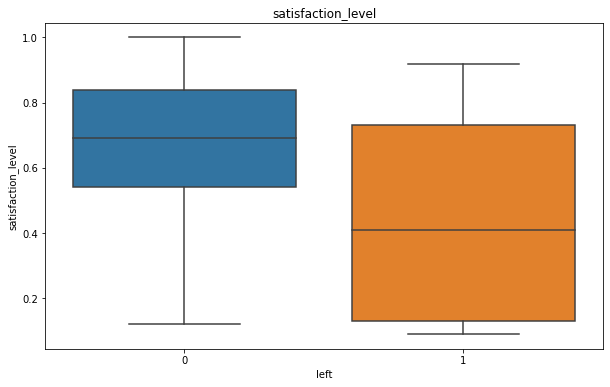

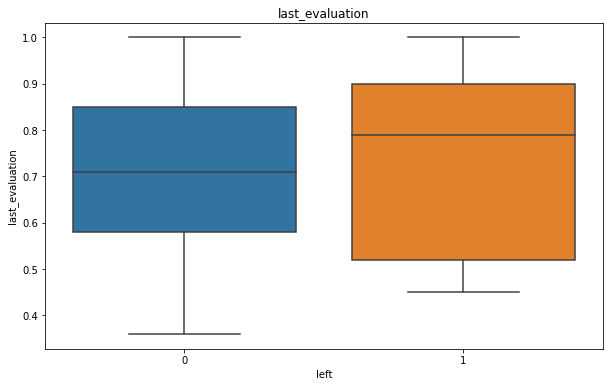

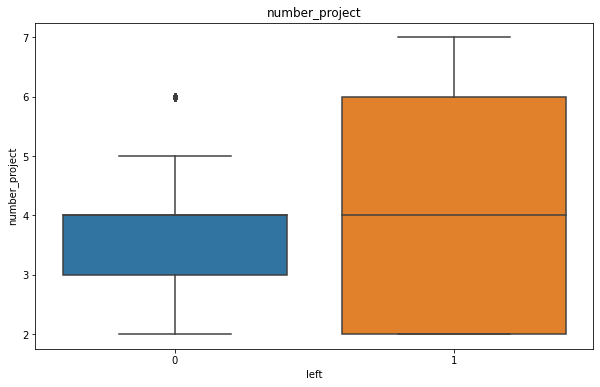

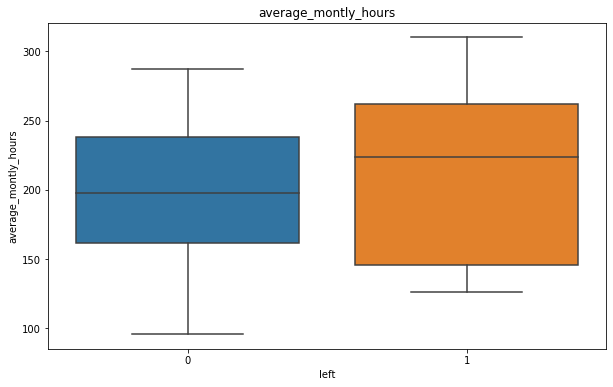

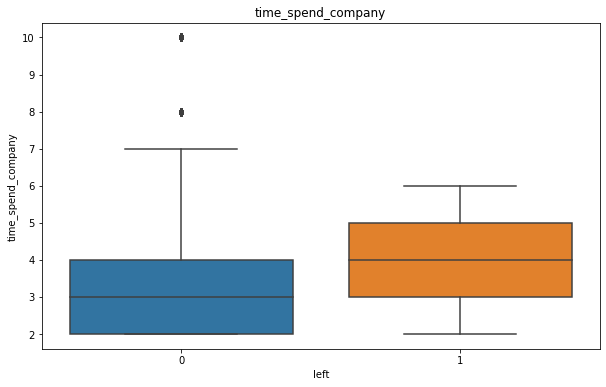

In [ ]:
make_countplots(df)

### Clear observations:

- generally, the more staisfied, they stay longer
- based on last evaluations people how are poor quality workers leave more, people who are excellent quality worker leave more too, average quality workers stay: this is a danger
- employees with so little or so many projects leave more: they get board or it is too much for them
- generally more hours of work means employees leave more
- after 5 years or so, people tend to leave more

In [ ]:
df.groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


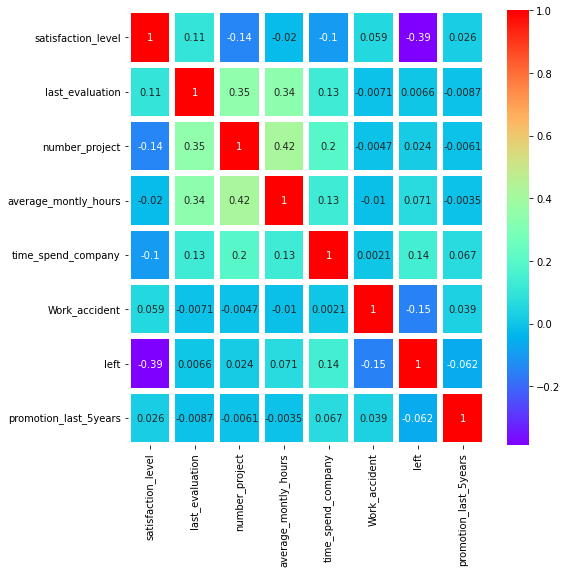

In [ ]:
plt.figure(figsize = (8, 8))
sns.heatmap(df.corr(), annot = True, cmap = "rainbow", linewidths = 5.0);

# 3) Model Selection

In [ ]:
for col in df.select_dtypes(['object']):
    dummies = pd.get_dummies(df[col], drop_first = True, prefix = 'is_' + str(col))
    df = pd.concat([df, dummies], axis = 1)
    df = df.drop(col, axis = 1)
    
df.rename(columns = {'left' : 'target'})
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,is_Departments _RandD,is_Departments _accounting,is_Departments _hr,is_Departments _management,is_Departments _marketing,is_Departments _product_mng,is_Departments _sales,is_Departments _support,is_Departments _technical,is_salary_low,is_salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0


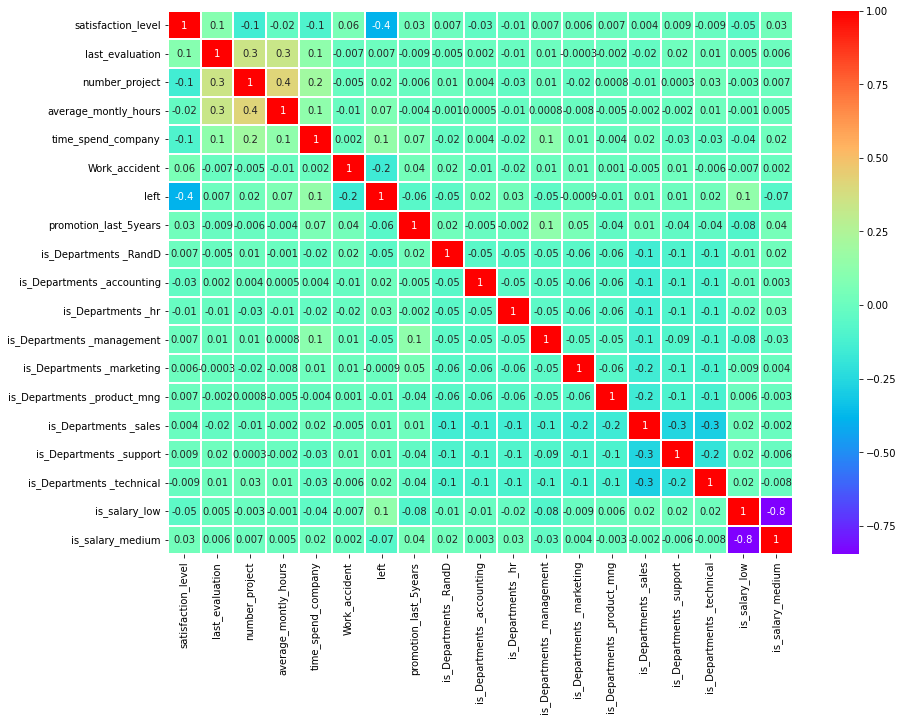

In [ ]:
plt.figure(figsize = (14, 10))
sns.heatmap(df.corr(), annot = True, cmap = "rainbow", linewidths = 1.0, fmt='.1g',);

In [ ]:
y = df['left']
x = df.drop('left', axis = 1) 
features = x.columns
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25, random_state = 2)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((11249, 18), (11249,), (3750, 18), (3750,))

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [ ]:
models = []
models.append(('LOG', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGBC', XGBClassifier()))

for model LOG, the accuracy mean and std are: 0.79972, 0.00695
for model KNN, the accuracy mean and std are: 0.93573, 0.00552
for model DT, the accuracy mean and std are: 0.98220, 0.00321
for model RF, the accuracy mean and std are: 0.99227, 0.00205
for model XGBC, the accuracy mean and std are: 0.97573, 0.00410


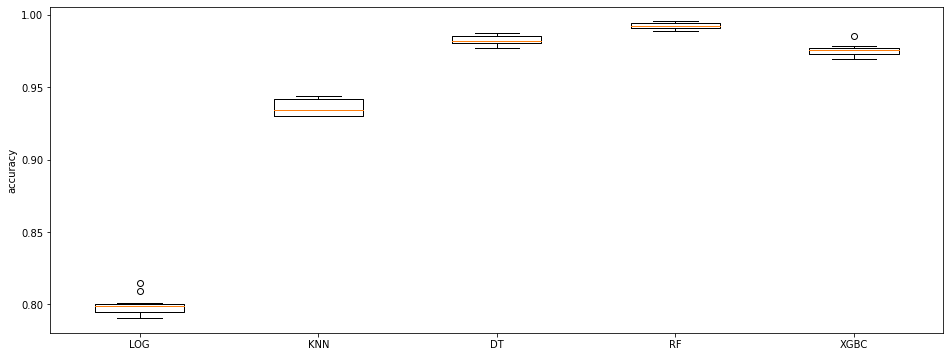

In [ ]:
metrics = []
methods = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits = 10, random_state = 2, shuffle = True)
    cv_metrics = cross_val_score(model, x, y, cv = kfold, scoring = scoring)
    metrics.append(cv_metrics)
    methods.append(name)
    print(f'for model {name}, the accuracy mean and std are: {cv_metrics.mean():.5f}, {cv_metrics.std():.5f}')
    
fig = plt.figure(figsize = (16, 6))
ax = fig.add_subplot()
plt.boxplot(metrics)
ax.set_xticklabels(methods)
ax.set_ylabel(scoring);

# 4) Hyperparameter Optimization

In [ ]:
rf = RandomForestClassifier()

In [ ]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 2)

# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 110, stop = 130, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# plit quality function
criterion = ['gini', 'entropy']

# Maximum number of levels in tree
max_depth = [6, 8]

# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'criterion' : criterion,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split}
print(param_grid)

{'n_estimators': [110, 115, 120, 125, 130], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt'], 'max_depth': [6, 8], 'min_samples_split': [5, 10]}


In [ ]:
# Grid search
search = GridSearchCV(rf, param_grid, scoring = 'accuracy', cv = cv, verbose = 2)
result = search.fit(x_train, y_train)
print(f'Best Score: {result.best_score_:.2f}')
print(f'Best Hyperparameters: {result.best_params_}' )

best_model = result.best_estimator_

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_split=5, n_estimators=110; total time=   0.7s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_split=5, n_estimators=110; total time=   0.6s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_split=5, n_estimators=110; total time=   0.7s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_split=5, n_estimators=110; total time=   0.7s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_split=5, n_estimators=110; total time=   0.7s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_split=5, n_estimators=115; total time=   0.7s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_split=5, n_estimators=115; total time=   0.7s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_split=5, n_estimators=115; total time=   0.7s
[CV] END criterion

# 5) Model Evaluation

In [ ]:
best_model.predict(x_val)

array([0, 1, 0, ..., 1, 0, 0])

In [ ]:
predictions = pd.DataFrame(best_model.predict(x_val), columns = ['Predicted Values'])
predictions ['Real Values'] = y_val.reset_index(drop = True)
predictions.head()

,Predicted Values,Real Values
0,0,0
1,1,1
2,0,0
3,0,1
4,0,0


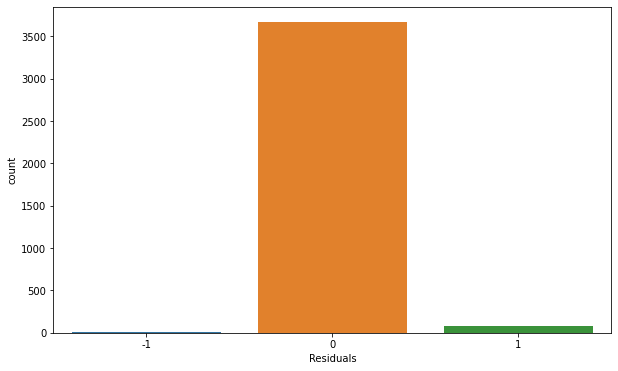

In [ ]:
# residuals
predictions['Residuals'] = predictions['Real Values'] - predictions['Predicted Values']
sns.countplot(predictions['Residuals']);

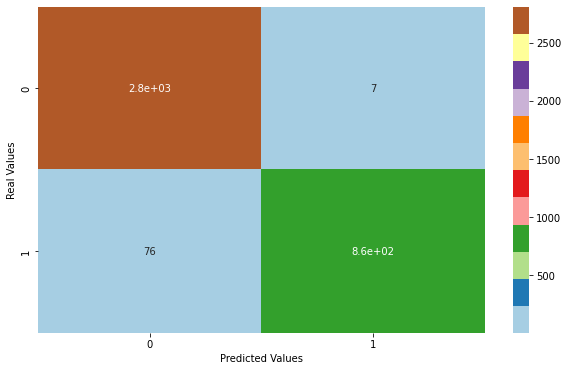

In [ ]:
cm = confusion_matrix(predictions['Real Values'], predictions['Predicted Values'])
sns.heatmap(cm, annot = True, cmap = 'Paired')
plt.xlabel('Predicted Values')
plt.ylabel('Real Values');

In [ ]:
acc = accuracy_score(predictions['Real Values'], predictions['Predicted Values'])
pre = precision_score(predictions['Real Values'], predictions['Predicted Values'])
rec = recall_score(predictions['Real Values'], predictions['Predicted Values'])
f1s = f1_score(predictions['Real Values'], predictions['Predicted Values'])

print(f'Accuracy is {acc:.5f}')
print(f'Precision is {pre:.5f}')
print(f'Recall is {rec:.5f}')
print(f'F1_score is {f1s:.5f}')

Accuracy is 0.97787
Precision is 0.99190
Recall is 0.91854
F1_score is 0.95381


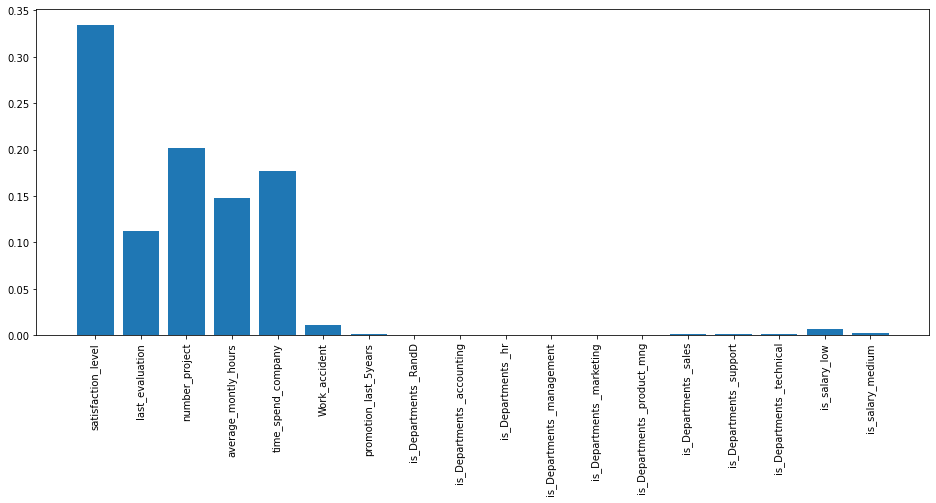

In [ ]:
plt.figure(figsize = (16, 6))
importance = best_model.feature_importances_
plt.bar(height = importance, x = features)
plt.xticks(rotation = 90);

# 6) Model Explanation

In [ ]:
val_df = pd.DataFrame(x_val, columns = features)
val_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,is_Departments _RandD,is_Departments _accounting,is_Departments _hr,is_Departments _management,is_Departments _marketing,is_Departments _product_mng,is_Departments _sales,is_Departments _support,is_Departments _technical,is_salary_low,is_salary_medium
0,1.472673,1.482942,-0.653771,0.168063,-0.338913,-0.414747,-0.147649,-0.236949,-0.233794,-0.22738,-0.210432,-0.249456,-0.257795,-0.613346,2.392457,-0.466288,1.029871,-0.870119
1,-0.950800,-1.318895,-1.466756,-0.993262,-0.338913,-0.414747,-0.147649,-0.236949,-0.233794,-0.22738,-0.210432,-0.249456,-0.257795,-0.613346,-0.417980,2.144599,1.029871,-0.870119
2,-0.304541,0.023652,0.972200,0.107994,0.348383,-0.414747,-0.147649,-0.236949,-0.233794,-0.22738,-0.210432,-0.249456,-0.257795,1.630402,-0.417980,-0.466288,-0.970996,-0.870119
3,-1.233539,-0.910294,0.159215,0.748725,-1.026208,-0.414747,-0.147649,-0.236949,4.277268,-0.22738,-0.210432,-0.249456,-0.257795,-0.613346,-0.417980,-0.466288,-0.970996,1.149268
4,1.109152,0.665739,-0.653771,-0.732965,-0.338913,-0.414747,-0.147649,-0.236949,-0.233794,-0.22738,-0.210432,-0.249456,-0.257795,-0.613346,-0.417980,-0.466288,1.029871,-0.870119


In [ ]:
val = pd.concat([val_df, predictions], axis = 1)
val['Residuals'] = np.abs(val['Residuals'])
val.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,is_Departments _RandD,is_Departments _accounting,is_Departments _hr,is_Departments _management,is_Departments _marketing,is_Departments _product_mng,is_Departments _sales,is_Departments _support,is_Departments _technical,is_salary_low,is_salary_medium,Predicted Values,Real Values,Residuals
0,1.472673,1.482942,-0.653771,0.168063,-0.338913,-0.414747,-0.147649,-0.236949,-0.233794,-0.22738,-0.210432,-0.249456,-0.257795,-0.613346,2.392457,-0.466288,1.029871,-0.870119,0,0,0
1,-0.950800,-1.318895,-1.466756,-0.993262,-0.338913,-0.414747,-0.147649,-0.236949,-0.233794,-0.22738,-0.210432,-0.249456,-0.257795,-0.613346,-0.417980,2.144599,1.029871,-0.870119,1,1,0
2,-0.304541,0.023652,0.972200,0.107994,0.348383,-0.414747,-0.147649,-0.236949,-0.233794,-0.22738,-0.210432,-0.249456,-0.257795,1.630402,-0.417980,-0.466288,-0.970996,-0.870119,0,0,0
3,-1.233539,-0.910294,0.159215,0.748725,-1.026208,-0.414747,-0.147649,-0.236949,4.277268,-0.22738,-0.210432,-0.249456,-0.257795,-0.613346,-0.417980,-0.466288,-0.970996,1.149268,0,1,1
4,1.109152,0.665739,-0.653771,-0.732965,-0.338913,-0.414747,-0.147649,-0.236949,-0.233794,-0.22738,-0.210432,-0.249456,-0.257795,-0.613346,-0.417980,-0.466288,1.029871,-0.870119,0,0,0


In [ ]:
val.groupby('Residuals').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,is_Departments _RandD,is_Departments _accounting,is_Departments _hr,is_Departments _management,is_Departments _marketing,is_Departments _product_mng,is_Departments _sales,is_Departments _support,is_Departments _technical,is_salary_low,is_salary_medium,Predicted Values,Real Values
Residuals,,,,,,,,,,,,,,,,,,,,
0,-0.034899,-0.002613,-0.003737,0.032921,0.005016,-0.020191,-0.002333,-0.014512,-0.012362,0.000921,-0.007436,-0.019536,-0.035553,0.026676,0.000481,0.022853,0.015524,-0.006084,0.233706,0.233706
1,-0.329846,0.277533,0.002495,0.151658,0.414628,-0.210468,0.019108,0.085262,-0.016393,0.051253,-0.031062,-0.198153,-0.058428,-0.099717,-0.079373,0.288667,0.210239,-0.140220,0.084337,0.915663


In [ ]:
# PFI, permutation feature importance
r = permutation_importance(best_model, x_train, y_train, n_repeats = 50, random_state = 2, scoring = 'accuracy')

for i in r.importances_mean.argsort()[::-1]:
    print(f"{features[i]:<40}" f"{r.importances_mean[i]:.3f}" f"    +/-    {r.importances_std[i]:.3f}")

satisfaction_level                      0.173    +/-    0.002
number_project                          0.111    +/-    0.002
average_montly_hours                    0.109    +/-    0.002
last_evaluation                         0.107    +/-    0.002
time_spend_company                      0.050    +/-    0.001
is_salary_low                           0.001    +/-    0.000
Work_accident                           0.000    +/-    0.000
is_Departments _technical               0.000    +/-    0.000
is_Departments _sales                   0.000    +/-    0.000
is_Departments _management              0.000    +/-    0.000
promotion_last_5years                   0.000    +/-    0.000
is_salary_medium                        0.000    +/-    0.000
is_Departments _marketing               0.000    +/-    0.000
is_Departments _support                 0.000    +/-    0.000
is_Departments _RandD                   0.000    +/-    0.000
is_Departments _hr                      0.000    +/-    0.000
is_Depar

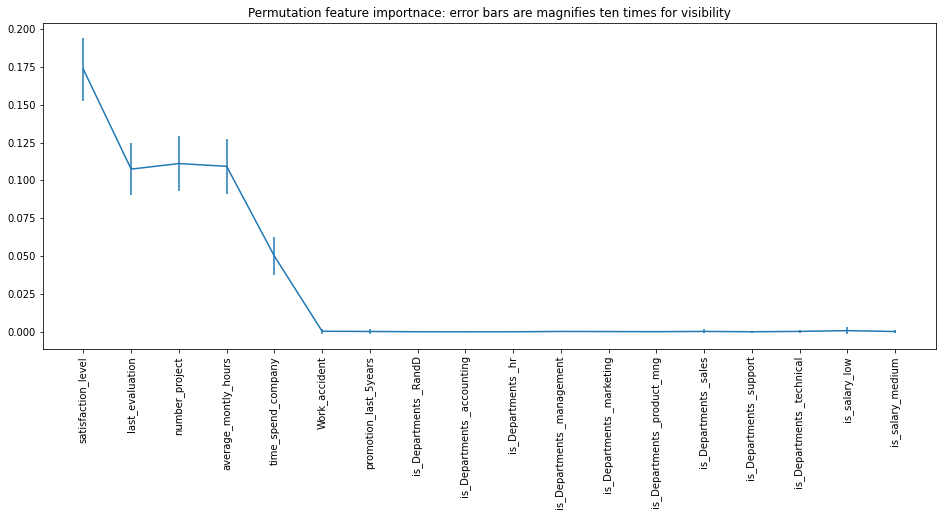

In [ ]:
plt.figure(figsize = (16, 6))
plt.errorbar(features, np.abs(r.importances_mean), yerr = 10 * (r.importances_std));
plt.xticks(rotation = 90)
plt.title('Permutation feature importnace: error bars are magnifies ten times for visibility');

### shap explainer

How much a features, has changed the prediction

The features are ranked by importance from top to bottom. And a line divides the impact of these features, separating the negative and the positive. There are dots on both sides for all features, and the amount of dots indicates how much a feature impacts the model negatively (left) or positively (right). The dots are color-coded, so you can attribute them to high, middle, or low feature values.

In [ ]:
# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(best_model)
shap_train = explainer.shap_values(x_train)
shap_val = explainer.shap_values(x_val)

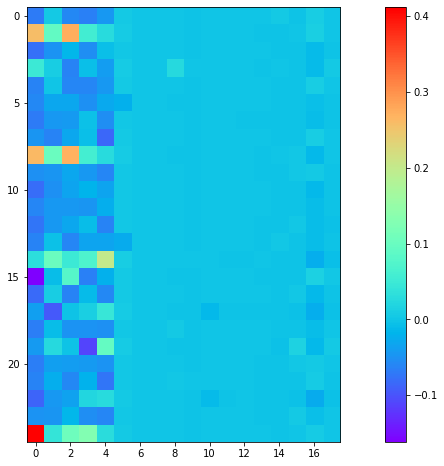

In [ ]:
plt.figure(figsize = (16, 8))
plt.imshow(shap_val[1][:25, :], cmap = 'rainbow')
plt.colorbar()
plt.show()

In [ ]:
shaps = np.abs(shap_val[1]).sum(0)
shap_importances = np.argsort(shaps)[::-1]
top_n = 5
important_features = list(shap_importances.flatten()[:top_n])
[features[x] for x in important_features]

['satisfaction_level',
 'number_project',
 'time_spend_company',
 'average_montly_hours',
 'last_evaluation']

### Shap summary plots

combines all shap values and provide global interpretation

In [1]:
shap.summary_plot(shap_train[1], x_train, plot_type = "dot", cmap = 'rainbow', feature_names = features)

NameError: ignored

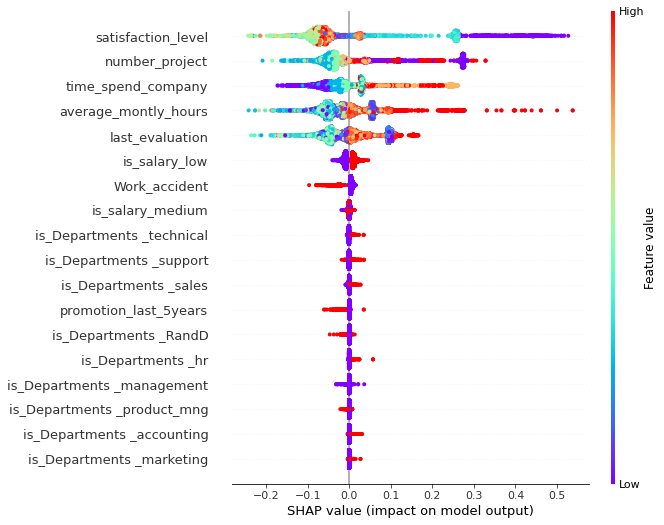

In [ ]:
shap.summary_plot(shap_train[1], x_train, plot_type = "dot", cmap = 'rainbow', feature_names = features)

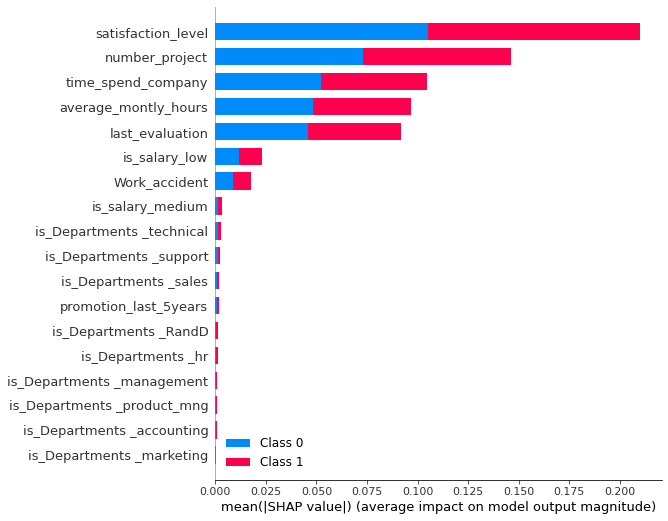

In [ ]:
shap.summary_plot(shap_val, x_val, plot_type = "bar", feature_names = features)

### shap force

In [ ]:
tn_indices = val[(val['Predicted Values'] == 0) & (val['Real Values'] == 0)].index
tp_indices = val[(val['Predicted Values'] == 1) & (val['Real Values'] == 1)].index
fp_indices = val[(val['Predicted Values'] == 1) & (val['Real Values'] == 0)].index
fn_indices = val[(val['Predicted Values'] == 0) & (val['Real Values'] == 1)].index

tn_instance = tn_indices[0]
tp_instance = tp_indices[0]
fp_instance = fp_indices[0]
fn_instance = fn_indices[0]

In [ ]:
shap.initjs()

In [ ]:
print(val[['Predicted Values', 'Real Values', 'Residuals']].iloc[0, :])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_val[1][0, :], x_val[0, :], feature_names = features)

Predicted Values    0
Real Values         0
Residuals           0
Name: 0, dtype: int64


In [ ]:
print(val[['Predicted Values', 'Real Values', 'Residuals']].iloc[tn_instance, :])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_val[1][tn_instance, :], x_val[tn_instance, :], feature_names = features)

Predicted Values    0
Real Values         0
Residuals           0
Name: 0, dtype: int64


In [ ]:
print(val[['Predicted Values', 'Real Values', 'Residuals']].iloc[fp_instance, :])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_val[1][fp_instance, :], x_val[fp_instance, :], feature_names = features)

Predicted Values    1
Real Values         0
Residuals           1
Name: 349, dtype: int64


In [ ]:
print(val[['Predicted Values', 'Real Values', 'Residuals']].iloc[fn_instance, :])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_val[1][fn_instance, :], x_val[fn_instance, :], feature_names = features)

Predicted Values    0
Real Values         1
Residuals           1
Name: 3, dtype: int64


### SHAP dependence plots

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. 
Each dot is a single prediction (row) from the dataset. The x-axis is the value of the feature.
The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction. 
The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (by default this second feature is chosen automatically). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring. 

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)

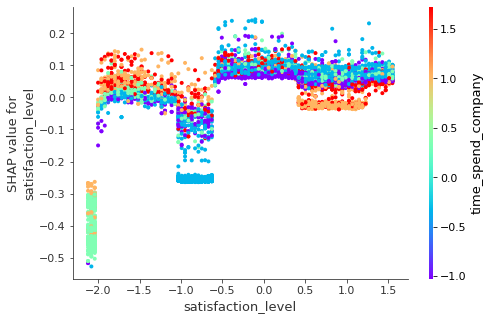

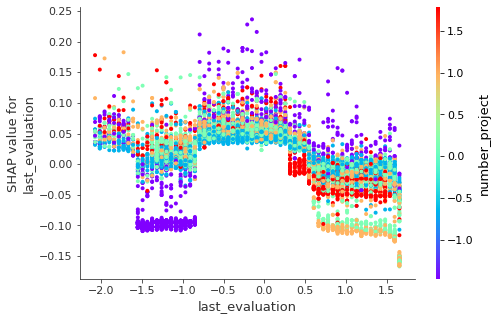

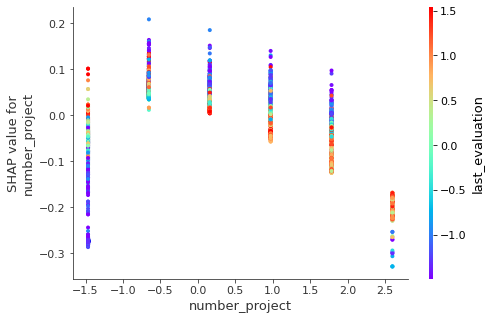

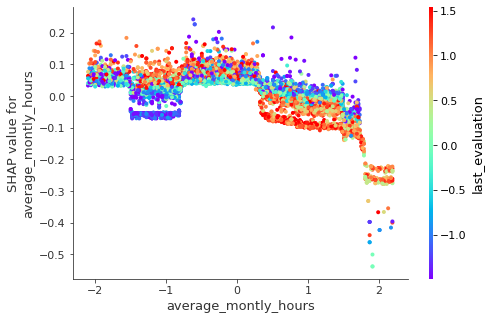

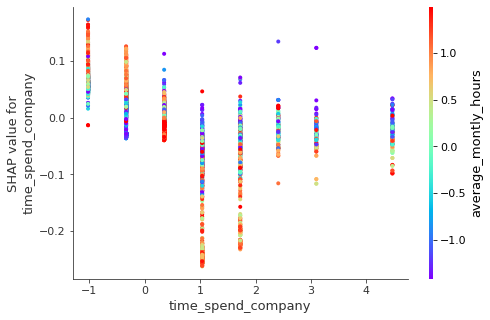

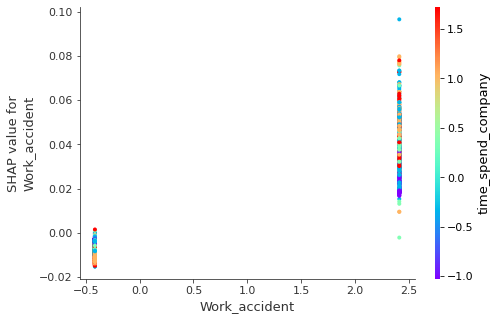

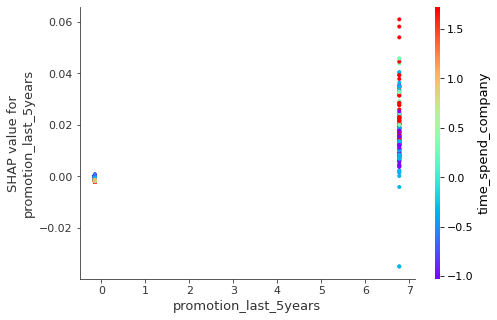

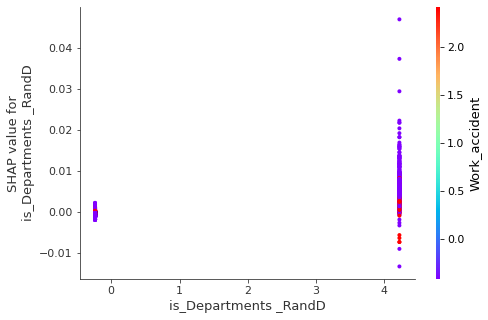

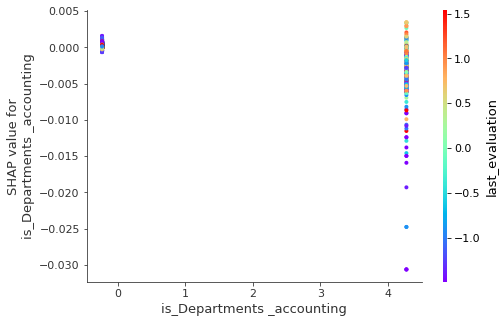

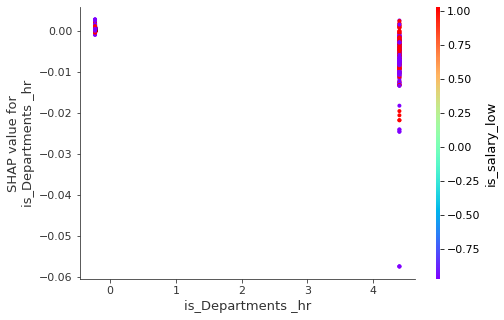

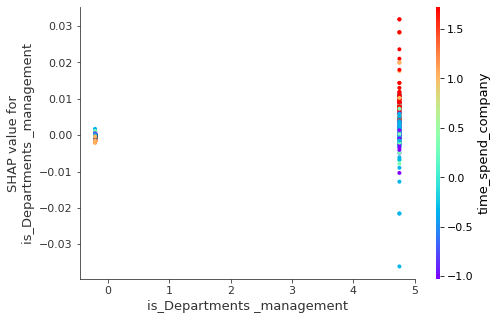

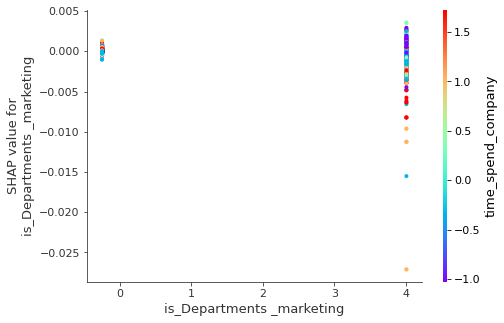

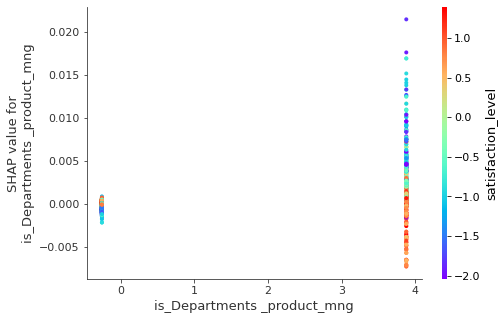

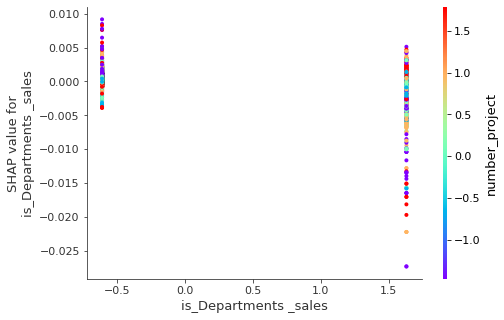

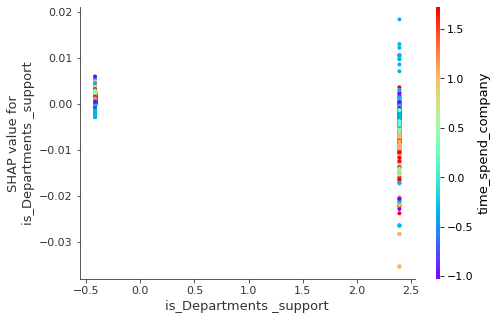

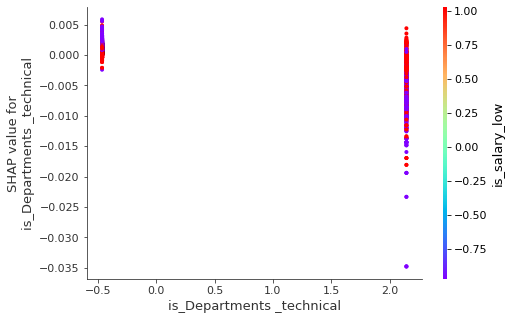

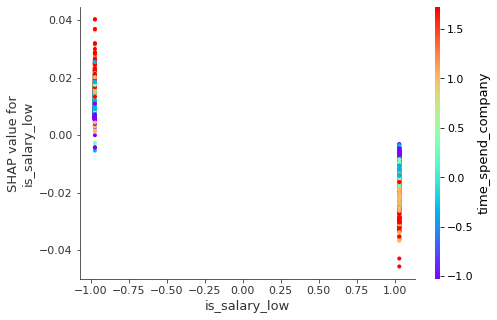

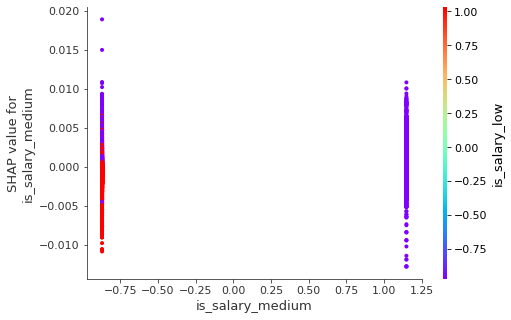

In [ ]:
for i in range(x_train.shape[1]):
    shap.dependence_plot(i, shap_train[0], x_train, cmap = 'rainbow', interaction_index = 'auto', feature_names = features)

### LIME, local explanations

In [ ]:
plt.rcParams["figure.figsize"] = (14, 10)

In [ ]:
cat = [features.to_list().index(x) for x in features.to_list() if x.startswith('is_')]

In [ ]:
lime_explainer = LimeTabularExplainer(x_val, feature_names = features, categorical_features = cat,
                                      class_names = ['stayed', 'left'], mode = 'classification')

In [ ]:
def make_lime2(lime_explainer, instance, model):

    exp = lime_explainer.explain_instance(instance, model.predict_proba, num_features = x_train.shape[1])
    exp.as_pyplot_figure()
    plt.tight_layout()

    for item in exp.as_list():
        print(item)

('time_spend_company <= -0.34', -0.04264068061831805)
('last_evaluation > 0.90', 0.038679693197925885)
('satisfaction_level > 0.79', -0.0224737272859011)
('is_salary_low=1', 0.021769861167932704)
('Work_accident <= -0.41', 0.020230139376971327)
('number_project <= -0.65', -0.01575496559172411)
('promotion_last_5years <= -0.15', -0.00905732415386403)
('is_Departments _product_mng=0', 0.006918143569239713)
('0.03 < average_montly_hours <= 0.91', -0.006165133730311932)
('is_Departments _marketing=0', 0.006066758102609005)
('is_Departments _support=2', -0.00592491850888897)
('is_Departments _technical=0', -0.004486272602396139)
('is_Departments _management=0', -0.003446947663796082)
('is_salary_medium=0', 0.0022183578936537025)
('is_Departments _RandD=0', 0.0021993534893423082)
('is_Departments _sales=0', -0.001321883011044005)
('is_Departments _hr=0', -0.0008151990091649023)
('is_Departments _accounting=0', -0.0003328009217446545)


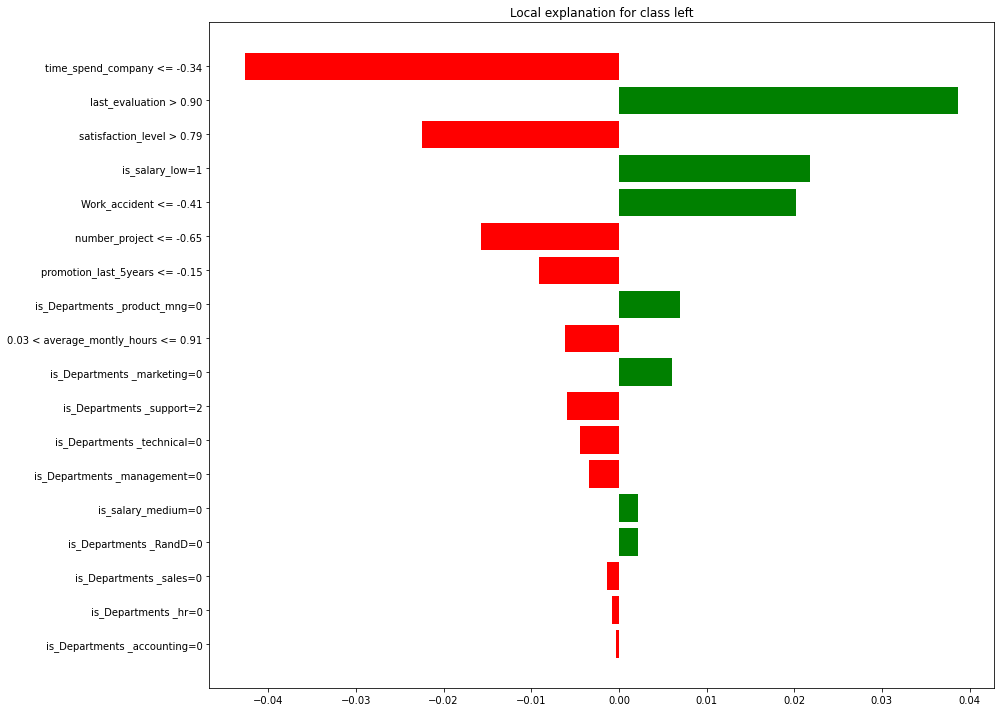

In [ ]:
make_lime2(lime_explainer, x_val[tn_instance], best_model);

('satisfaction_level <= -0.75', 0.06332399843066404)
('time_spend_company <= -0.34', -0.04582583301225963)
('Work_accident <= -0.41', 0.023247995701375236)
('is_salary_low=1', 0.023136959760217114)
('number_project <= -0.65', -0.017804894783491575)
('average_montly_hours <= -0.87', -0.015600313404701511)
('is_Departments _support=0', -0.00887277317114424)
('is_Departments _marketing=0', 0.006214321357819979)
('is_Departments _RandD=0', 0.0061166165678477125)
('is_Departments _technical=2', 0.0060214939780373665)
('is_Departments _product_mng=0', 0.00567465992988532)
('last_evaluation <= -0.91', -0.004774795100397855)
('promotion_last_5years <= -0.15', 0.003618373408274099)
('is_Departments _accounting=0', 0.0030038437388350487)
('is_Departments _management=0', 0.0025246070760684054)
('is_Departments _hr=0', 0.0022890663124441107)
('is_Departments _sales=0', -0.0018531432781371997)
('is_salary_medium=0', 0.0016036645775121885)


<Figure size 1152x864 with 0 Axes>

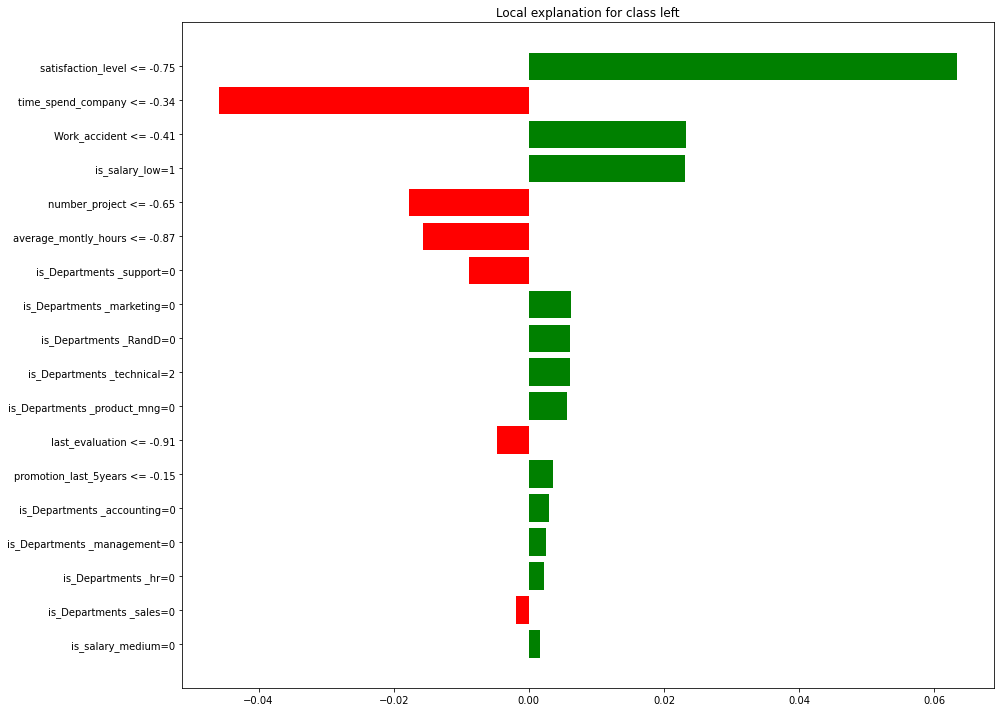

In [ ]:
make_lime(lime_explainer, x_val[tp_instance], best_model)

('average_montly_hours > 0.91', 0.06391079834537405)
('time_spend_company > 0.35', 0.057169851027295555)
('last_evaluation > 0.90', 0.039463686993214606)
('Work_accident <= -0.41', 0.025809452139462286)
('satisfaction_level > 0.79', -0.020718816300690335)
('is_salary_low=1', 0.019011317055329293)
('-0.65 < number_project <= 0.16', -0.010411469780918505)
('is_Departments _accounting=0', -0.010152806158887796)
('is_Departments _hr=0', -0.008529933251683795)
('promotion_last_5years <= -0.15', 0.007593710140735038)
('is_Departments _sales=0', -0.006454117308203872)
('is_Departments _product_mng=3', -0.00507852198399447)
('is_Departments _technical=0', -0.004943190750144448)
('is_Departments _marketing=0', 0.004940034885349219)
('is_Departments _management=0', 0.0045391505241600605)
('is_Departments _RandD=0', -0.003208337167914425)
('is_salary_medium=0', 0.0022640497805660313)
('is_Departments _support=0', 0.0011503535359233565)


<Figure size 1152x864 with 0 Axes>

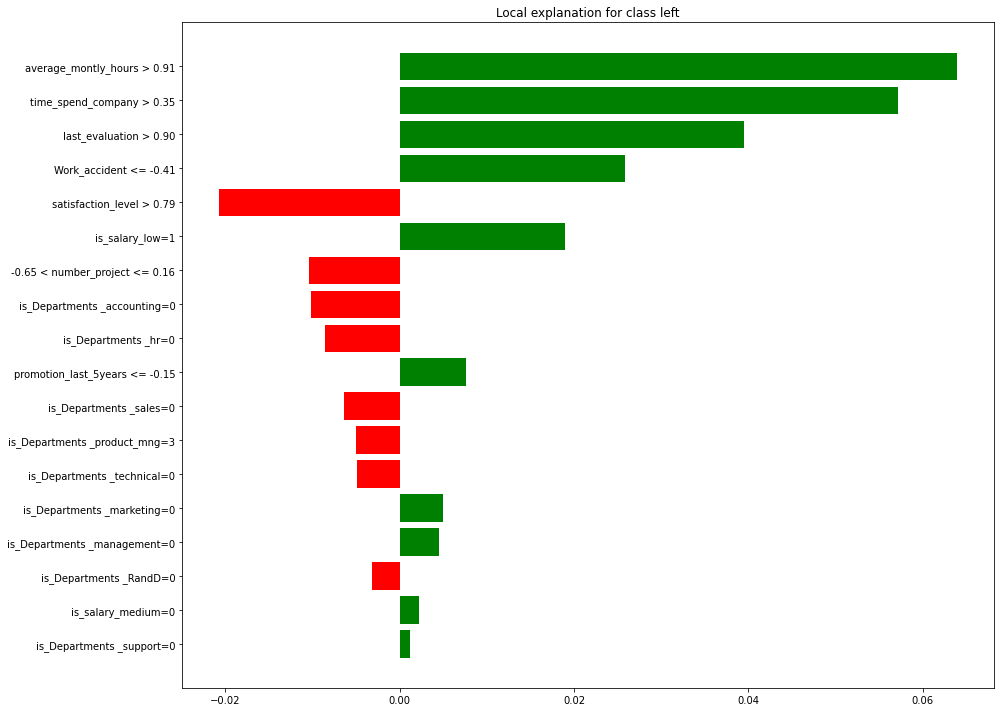

In [ ]:
make_lime(lime_explainer, x_val[fp_instance], best_model)

('satisfaction_level <= -0.75', 0.06756116490080649)
('time_spend_company <= -0.34', -0.04034045275363401)
('is_salary_low=0', -0.02154196199259608)
('Work_accident <= -0.41', 0.01994616287338511)
('-0.65 < number_project <= 0.16', -0.01559766408788393)
('promotion_last_5years <= -0.15', 0.012027051661950885)
('is_Departments _product_mng=0', 0.010448757680231761)
('is_Departments _marketing=0', -0.0063003273809643144)
('last_evaluation <= -0.91', -0.006214947754464642)
('is_Departments _accounting=4', -0.004087196123756047)
('is_Departments _hr=0', -0.0037857302375666193)
('is_Departments _management=0', 0.0037665076627839533)
('is_Departments _RandD=0', 0.003193812049874186)
('is_Departments _technical=0', -0.0026779376168611846)
('is_Departments _sales=0', -0.002633508231664902)
('is_Departments _support=0', 0.0009899801410145179)
('0.03 < average_montly_hours <= 0.91', 5.409294799809053e-05)
('is_salary_medium=1', 2.957865680905406e-05)


<Figure size 1152x864 with 0 Axes>

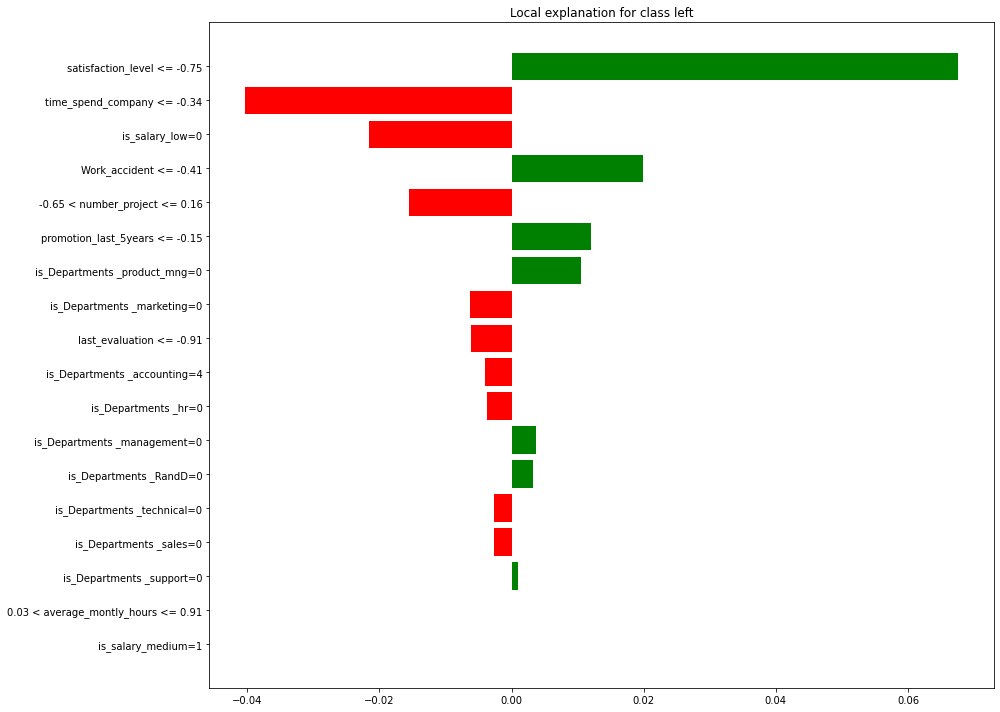

In [ ]:
make_lime(lime_explainer, x_val[fn_instance], best_model)

# 7) What else?

- The dataset is imbalanced. Techniques such as under and over sampling might be used to generate a more balanced dataset. Maybe over sampling with SMOTE, or borderline SVM, or ADASYN, or GANs as well as undersampling with CNN, Tomek Links, and ideally combination of over and undersampling.
- Alternatively, cost sensitive learning can be used for imbalanced datasets.
- Probability thresholding can be used to improve the model where the 0.5 decision threshold is moved
- Probability scaling can be used to remove the effect of the majority class
- Performing feature selection to reduce overfitting, as well, doing feature engineering to generate helpful features
- Choose a relevant performance metrics
- Deep Learning
- People leaving the company, often have different reasons at different departments: category-wise churn prediction. As well, retention policies often need to be added to the data, which is usually missing
- Enriching the dataset, moer featureengineering. Simple factors such as "location" of an employee play big roles, they are often neglected. It makes a difference if an IT guy employee lives in the Bay Area or some non-technical neighbourhood
- Causality Analysis
- Employee chrun is not nice, but keep in mind some employees are better to leave. Next step is defining a value metric, to find the value of each employee that might want to leave and try to avoid it. Probably, we might be fine letting an underperformer go.

# 8) How succesful we are at keeping our employees?

In [ ]:
val['chrun_chance'] = best_model.predict_proba(x_val)[:, 1]
val.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,is_Departments _RandD,is_Departments _accounting,is_Departments _hr,is_Departments _management,is_Departments _marketing,is_Departments _product_mng,is_Departments _sales,is_Departments _support,is_Departments _technical,is_salary_low,is_salary_medium,Predicted Values,Real Values,Residuals,chrun_chance
0,1.472673,1.482942,-0.653771,0.168063,-0.338913,-0.414747,-0.147649,-0.236949,-0.233794,-0.22738,-0.210432,-0.249456,-0.257795,-0.613346,2.392457,-0.466288,1.029871,-0.870119,0,0,0,0.024985
1,-0.950800,-1.318895,-1.466756,-0.993262,-0.338913,-0.414747,-0.147649,-0.236949,-0.233794,-0.22738,-0.210432,-0.249456,-0.257795,-0.613346,-0.417980,2.144599,1.029871,-0.870119,1,1,0,0.966596
2,-0.304541,0.023652,0.972200,0.107994,0.348383,-0.414747,-0.147649,-0.236949,-0.233794,-0.22738,-0.210432,-0.249456,-0.257795,1.630402,-0.417980,-0.466288,-0.970996,-0.870119,0,0,0,0.025875
3,-1.233539,-0.910294,0.159215,0.748725,-1.026208,-0.414747,-0.147649,-0.236949,4.277268,-0.22738,-0.210432,-0.249456,-0.257795,-0.613346,-0.417980,-0.466288,-0.970996,1.149268,0,1,1,0.213342
4,1.109152,0.665739,-0.653771,-0.732965,-0.338913,-0.414747,-0.147649,-0.236949,-0.233794,-0.22738,-0.210432,-0.249456,-0.257795,-0.613346,-0.417980,-0.466288,1.029871,-0.870119,0,0,0,0.026245


In [ ]:
bins = np.linspace(0, 1.0, 11)

In [ ]:
val.groupby(pd.cut(val['chrun_chance'], bins)).mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,is_Departments _RandD,is_Departments _accounting,is_Departments _hr,is_Departments _management,is_Departments _marketing,is_Departments _product_mng,is_Departments _sales,is_Departments _support,is_Departments _technical,is_salary_low,is_salary_medium,Predicted Values,Real Values,Residuals,chrun_chance
chrun_chance,,,,,,,,,,,,,,,,,,,,,,
"(0.0, 0.1]",0.261865,-0.051626,-0.062151,-0.061695,-0.196962,0.100496,0.025432,0.029156,-0.042724,0.000247,0.017778,-0.014132,-0.024169,0.012080,0.006023,-0.002879,-0.071050,0.041415,0.0,0.009278,0.009278,0.032396
"(0.1, 0.2]",-0.336347,0.266290,0.258359,0.301595,0.678859,-0.198131,0.093481,-0.050583,0.222028,-0.050103,0.014354,-0.071414,-0.027169,0.058997,-0.075244,0.088639,0.123555,-0.075029,0.0,0.083624,0.083624,0.135612
"(0.2, 0.3]",-0.448568,0.547460,0.298278,0.606721,0.927158,-0.117288,0.307643,-0.002357,0.062986,-0.166520,0.116053,-0.025342,-0.094498,-0.052409,-0.011207,0.152080,-0.023217,-0.019851,0.0,0.131579,0.131579,0.239038
"(0.3, 0.4]",-0.856554,0.235735,-0.274377,0.246152,0.531662,-0.414747,-0.147649,0.357352,0.066943,0.080974,0.120406,-0.107517,0.017995,-0.089804,-0.043255,-0.031140,-0.304040,0.341513,0.0,0.366667,0.366667,0.341483
"(0.4, 0.5]",0.108026,0.578182,0.739919,0.721551,1.477511,0.392640,0.346668,0.081427,0.410643,0.102999,-0.210432,-0.249456,0.037695,0.027725,-0.016489,0.093188,-0.256400,0.428058,0.0,0.571429,0.571429,0.443478
"(0.5, 0.6]",-0.262024,0.066662,0.330370,0.503182,0.890984,-0.266018,-0.147649,-0.236949,0.003630,0.259495,0.050756,0.422887,-0.040066,0.095206,-0.417980,0.083373,-0.128526,0.192716,1.0,0.736842,0.263158,0.557880
"(0.6, 0.7]",0.700099,0.962904,0.440064,0.869226,1.173137,-0.209230,-0.147649,-0.236949,0.176303,0.193103,-0.210432,-0.249456,-0.032148,-0.205391,0.144107,0.483125,-0.534443,0.561810,1.0,0.981818,0.018182,0.663037
"(0.7, 0.8]",0.824089,1.199483,0.668062,0.895943,1.154348,-0.414747,-0.147649,-0.076616,-0.103979,-0.061002,-0.139028,0.087521,-0.079226,0.032337,0.067275,0.059646,0.526055,-0.390696,1.0,1.000000,0.000000,0.753163
"(0.8, 0.9]",-0.490185,0.791463,0.675148,0.889655,0.731682,0.074344,-0.014564,0.020200,0.113211,0.039465,-0.114998,-0.167569,-0.019130,0.379081,-0.201793,-0.315660,0.452698,-0.287604,1.0,1.000000,0.000000,0.841202


In [ ]:
health = (100 * val.groupby(pd.cut(val['chrun_chance'], bins)).count()['chrun_chance']) / len(val)
health

chrun_chance
(0.0, 0.1]    66.106667
(0.1, 0.2]     7.653333
(0.2, 0.3]     2.026667
(0.3, 0.4]     0.800000
(0.4, 0.5]     0.373333
(0.5, 0.6]     0.506667
(0.6, 0.7]     1.466667
(0.7, 0.8]     3.706667
(0.8, 0.9]     1.386667
(0.9, 1.0]    15.973333
Name: chrun_chance, dtype: float64

In [ ]:
b_l = []
for i in range(10):
    b = str(int(i * 10)) + '-' + str(int((i + 1) * 10)) + '%'
    b_l.append(b)

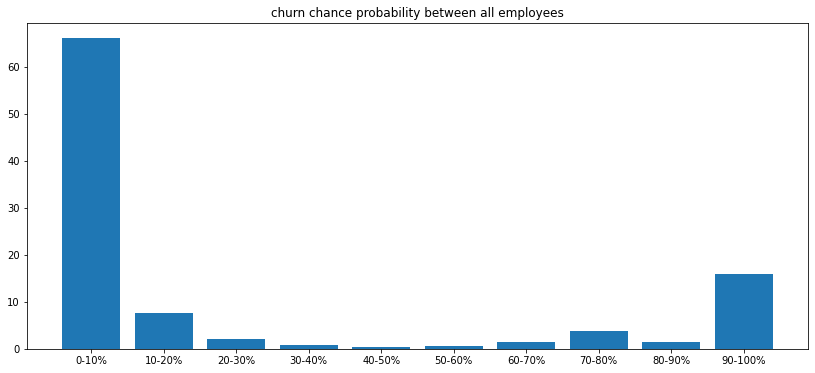

In [ ]:
plt.rcParams["figure.figsize"] = (14, 6)
plt.bar(x = b_l, height = health.to_list());
plt.title('churn chance probability between all employees');